In [6]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras

##########데이터 로드import pathlib
# !pip install openpyxl
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

print(tf.__version__)

2.8.0


In [2]:
abalone_train = pd.read_csv(
    "https://storage.googleapis.com/download.tensorflow.org/data/abalone_train.csv",
    names=["Length", "Diameter", "Height", "Whole weight", "Shucked weight",
        "Viscera weight", "Shell weight", "Age"])

abalone_train.head()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Age
0,0.435,0.335,0.110,0.334,0.1355,0.0775,0.0965,7
1,0.585,0.450,0.125,0.874,0.3545,0.2075,0.2250,6
2,0.655,0.510,0.160,1.092,0.3960,0.2825,0.3700,14
3,0.545,0.425,0.125,0.768,0.2940,0.1495,0.2600,16
4,0.545,0.420,0.130,0.879,0.3740,0.1695,0.2300,13


In [3]:
import numpy as np
abalone_features = abalone_train.copy()
abalone_labels = abalone_features.pop('Age')
abalone_features = np.array(abalone_features)
abalone_features

array([[0.435, 0.335, 0.11 , ..., 0.136, 0.077, 0.097],
       [0.585, 0.45 , 0.125, ..., 0.354, 0.207, 0.225],
       [0.655, 0.51 , 0.16 , ..., 0.396, 0.282, 0.37 ],
       ...,
       [0.53 , 0.42 , 0.13 , ..., 0.374, 0.167, 0.249],
       [0.395, 0.315, 0.105, ..., 0.118, 0.091, 0.119],
       [0.45 , 0.355, 0.12 , ..., 0.115, 0.067, 0.16 ]])

In [5]:
x_train = abalone_features.copy()
y_train = abalone_labels.copy()
np.shape(x_train)

(3320, 7)

In [9]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[7]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse', 'acc'])
    return model
model = build_model()

example_batch = x_train[:10]
example_result = model.predict(example_batch)
example_result

array([[0.005],
       [0.01 ],
       [0.03 ],
       [0.015],
       [0.016],
       [0.006],
       [0.005],
       [0.028],
       [0.004],
       [0.004]], dtype=float32)

In [10]:
# 에포크가 끝날 때마다 점(.)을 출력해 훈련 진행 과정을 표시합니다
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

EPOCHS = 1000

history = model.fit(
    x_train, y_train,
    epochs=EPOCHS, validation_split = 0.2, verbose=0,
    callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [11]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,acc,val_loss,val_mae,val_mse,val_acc,epoch
995,3.760578,1.401501,3.760578,0.000377,4.223636,1.487972,4.223636,0.0,995
996,3.744602,1.391480,3.744602,0.000377,4.155021,1.462531,4.155021,0.0,996
997,3.728011,1.390514,3.728011,0.000377,4.199389,1.490090,4.199389,0.0,997
998,3.723973,1.393103,3.723973,0.000377,4.261760,1.464518,4.261760,0.0,998
999,3.737887,1.396788,3.737887,0.000377,4.436679,1.565915,4.436679,0.0,999


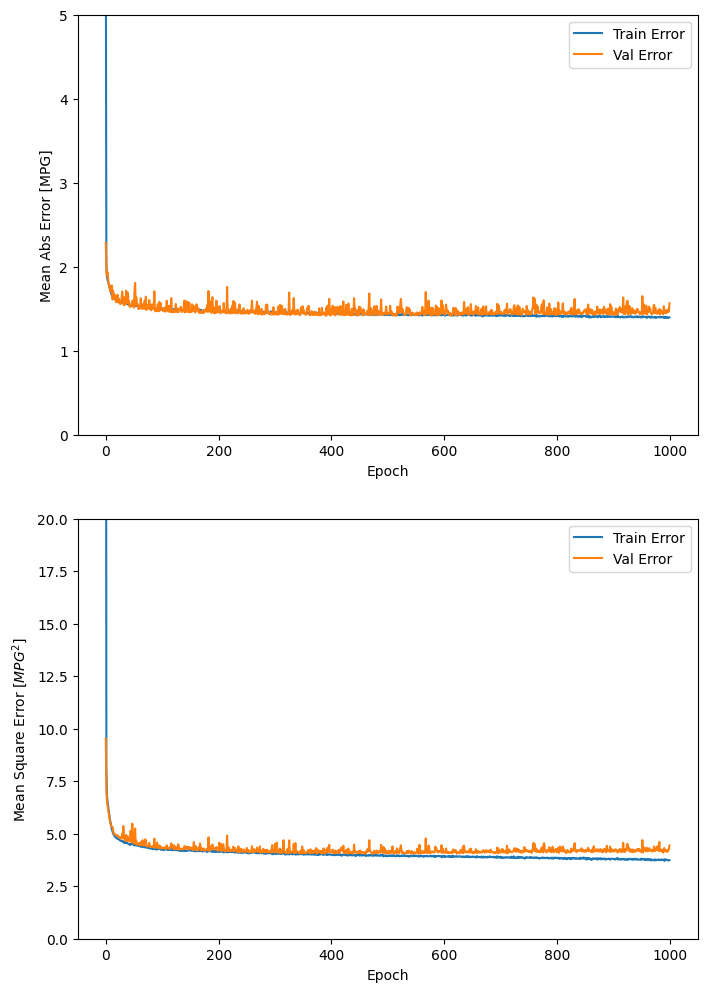

In [13]:
import matplotlib.pyplot as plt

def plot_history(history):
        hist = pd.DataFrame(history.history)
        hist['epoch'] = history.epoch

        plt.figure(figsize=(8,12))

        plt.subplot(2,1,1)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Abs Error [MPG]')
        plt.plot(hist['epoch'], hist['mae'],
                label='Train Error')
        plt.plot(hist['epoch'], hist['val_mae'],
                label = 'Val Error')
        plt.ylim([0,5])
        plt.legend()

        plt.subplot(2,1,2)
        plt.xlabel('Epoch')
        plt.ylabel('Mean Square Error [$MPG^2$]')
        plt.plot(hist['epoch'], hist['mse'],
                label='Train Error')
        plt.plot(hist['epoch'], hist['val_mse'],
                label = 'Val Error')
        plt.ylim([0,20])
        plt.legend()
        plt.show()

plot_history(history)